# Forecasting the price of a car

In this project, we will analyze data from a car-selling app called Rusty Bargain. Users can list their cars for sale, and our objective is to develop a model capable of predicting a car's price based on historical sales data. For this project, in particular, we aim to delve into and compare the quality and efficiency of different models, incorporating gradient boosting to achieve superior results more swiftly.

## Initializing

In [149]:
# Importing important modules and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [150]:
# Uploading the DataFrame

df = pd.read_csv('/datasets/car_data.csv')

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Here are the columns of the DataFrame:

- `DateCrawled` — Date when the profile was downloaded from the database
- `VehicleType`
- `RegistrationYear`
- `Gearbox`
- `Power` (hp)
- `Model`
- `Mileage` (Km)
- `RegistrationMonth`
- `FuelType`
- `Brand`
- `NotRepaired` —  Whether the vehicle was repaired
- `DateCreated` — Profile creation date
- `NumberOfPictures`
- `PostalCode` — User's postal code
- `LastSeen` — Last user visit

In [151]:
# Some informations

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We've observed the presence of missing values in the dataset, which contains almost 355 thousand lines of information. Moreover, there seems to be an issue with the date types, indicating a need for correction.

## Data Preparation

Initially, we'll address the correction of the date types.

In [152]:
# Using 'to_datetime' to correct date types.

df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = "%d/%m/%Y %H:%M")
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = "%d/%m/%Y %H:%M")
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = "%d/%m/%Y %H:%M")

# Checking

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

We can also identify and remove duplicated rows.

In [153]:
print(f'Number of duplicated rows = {df.duplicated().sum()}')

df = df.drop_duplicates()

print(f'Number of duplicated rows after the removing process = {df.duplicated().sum()} ')

Number of duplicated rows = 262
Number of duplicated rows after the removing process = 0 


Next, we can proceed to address the missing values.

In [154]:
# Looking for missing values

df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

We have identified missing values in five columns: 'VehicleType,' 'Gearbox', 'Model', 'FuelType,' and 'NotRepaired.' We will inspect the data, and in the absence of any observable reasons for these gaps, we will proceed to fill the corresponding rows with 'unknown.'

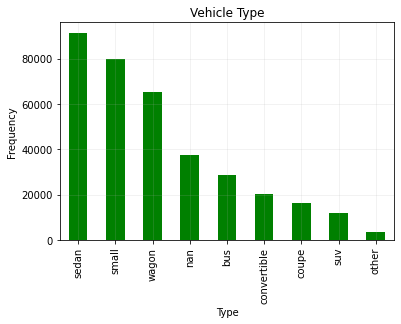

In [112]:
# Analyzing the 'VehicleType' column.

df['VehicleType'].value_counts(dropna = False).plot(kind = 'bar', color = 'green')

plt.title('Vehicle Type')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.grid(alpha = 0.2)

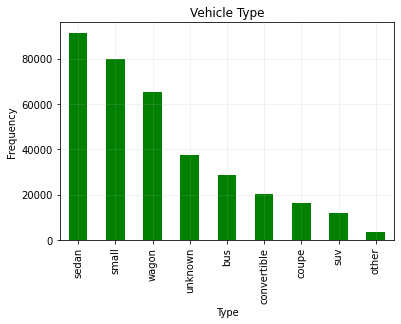

In [113]:
# Replacing missing values for 'unknown'

df['VehicleType'] = df['VehicleType'].fillna('unknown')

df['VehicleType'].value_counts(dropna = False).plot(kind = 'bar', color = 'green')

plt.title('Vehicle Type')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.grid(alpha = 0.2)

In [114]:
# Analyzing the 'Gearbox' column.

df['Gearbox'].value_counts(dropna = False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

In [155]:
df[df['Gearbox'].isnull()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:00,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:00
16,2016-04-01 12:46:00,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:00
32,2016-03-15 20:59:00,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:00
37,2016-03-28 17:50:00,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:00
40,2016-03-26 22:06:00,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:00,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:00
354305,2016-04-03 13:46:00,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:00
354329,2016-03-30 20:55:00,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:00
354338,2016-03-31 19:52:00,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:00


<AxesSubplot:>

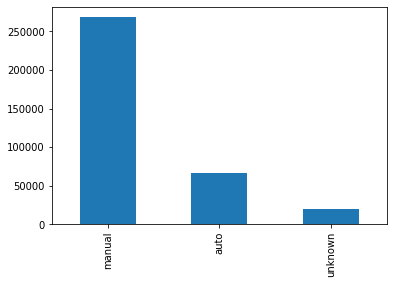

In [115]:
# Replacing missing values for 'unknown'

df['Gearbox'] = df['Gearbox'].fillna('unknown')

df['Gearbox'].value_counts(dropna = False).plot(kind = 'bar')

In [116]:
# Analyzing the 'Model' column.

df['Model'].unique().size

251

The values in this column cover a variety of options.

In [117]:
df[df['Model'].isnull()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
59,2016-03-29 15:48:00,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:00
81,2016-04-03 12:56:00,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:00
115,2016-03-20 18:53:00,0,small,1999,unknown,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:00
135,2016-03-27 20:51:00,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,2016-03-07 16:37:00,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:00
354321,2016-03-15 13:52:00,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:00
354338,2016-03-31 19:52:00,180,unknown,1995,unknown,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:00
354351,2016-03-11 23:40:00,1900,unknown,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,0,87700,2016-03-12 14:16:00


In [118]:
# Replacing missing values for 'unknown'

df['Model'] = df['Model'].fillna('unknown')

df[df['Model'].isnull()].size

0

In [119]:
# Analyzing the 'FuelType' column.

df['FuelType'].value_counts(dropna = False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [156]:
df[df['FuelType'].isnull()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,2016-03-17 10:53:00,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:00
13,2016-03-21 21:37:00,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21,0,90762,2016-03-23 02:50:00
26,2016-03-10 19:38:00,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:00
36,2016-03-11 11:50:00,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:00
41,2016-03-30 20:38:00,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30,0,33649,2016-04-03 11:44:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354339,2016-03-20 12:46:00,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,2016-03-20,0,53947,2016-03-26 21:18:00
354346,2016-03-07 17:06:00,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,0,61169,2016-03-08 21:28:00
354351,2016-03-11 23:40:00,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,0,87700,2016-03-12 14:16:00
354361,2016-03-09 13:37:00,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,0,51371,2016-03-13 01:44:00


In [120]:
# Replacing missing values for 'unknown'

df['FuelType'] = df['FuelType'].fillna('unknown')

df[df['FuelType'].isnull()].size

0

In [121]:
# Analyzing the 'NotRepaired' column.

df['NotRepaired'].value_counts(dropna = False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

In [157]:
df[df['NotRepaired'].isnull()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00
8,2016-04-04 23:42:00,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:00
9,2016-03-17 10:53:00,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:00
12,2016-03-15 22:49:00,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15,0,37269,2016-04-01 13:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,2016-03-16 17:06:00,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,2016-03-16,0,56472,2016-03-18 11:30:00
354356,2016-04-04 11:45:00,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,2016-04-04,0,88477,2016-04-06 12:44:00
354357,2016-03-09 11:36:00,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,2016-03-09,0,18246,2016-04-04 08:15:00
354365,2016-03-14 17:48:00,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:00


In [122]:
# Replacing missing values for 'unknown'

df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

df[df['NotRepaired'].isnull()].size

0

Upon initial inspection, there doesn't seem to be a discernible pattern in the missing values across the columns. Therefore, all missing values were uniformly filled with the information 'unknown'. The 'Price' column is also interesting to investigate.

<AxesSubplot:ylabel='Frequency'>

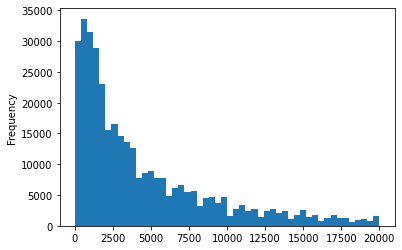

In [123]:
# Analyzing the 'Price' column.

df['Price'].plot(kind = 'hist', bins = 50)

In [124]:
df[df['Price'] == 0].shape

(10772, 16)

It's important to note that predicting a price of 0 for any car is not realistic. Even in cases where some components may be reused, we should exclude such instances from our analysis.

In [125]:
df = df[df['Price'] != 0]

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343597 non-null  datetime64[ns]
 1   Price              343597 non-null  int64         
 2   VehicleType        343597 non-null  object        
 3   RegistrationYear   343597 non-null  int64         
 4   Gearbox            343597 non-null  object        
 5   Power              343597 non-null  int64         
 6   Model              343597 non-null  object        
 7   Mileage            343597 non-null  int64         
 8   RegistrationMonth  343597 non-null  int64         
 9   FuelType           343597 non-null  object        
 10  Brand              343597 non-null  object        
 11  NotRepaired        343597 non-null  object        
 12  DateCreated        343597 non-null  datetime64[ns]
 13  NumberOfPictures   343597 non-null  int64   

The DataFrame appears to be consistent and ready for use in training our models.

## Models training

We've decided to exclude certain columns from building our machine learning model:

- `Model`: It's a categorical variable with numerous distinct values. Even with One Hot Encoding (OHE), including this would result in too many columns, negatively impacting processing time.
- `DateCreated:` Corresponds to the profile creation date, not the car itself.
- `PostalCode:` Similar to 'Model,' it's categorical, and despite being presented as numbers, the values lack operational significance. We'll also disregard this.
- `LastSeen:` Corresponds to the profile announcement, not the car.

For the remaining columns, which will be used, we plan to employ One Hot Encoding to leverage the categorical information.

In [129]:
# Employing One Hot Encoding to handle the categorical variables

categorical_data = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']

df_ohe = pd.get_dummies(df[categorical_data], drop_first=True)

df_final = df.drop(categorical_data, axis = 1).join(df_ohe)

df_final

,DateCrawled,Price,RegistrationYear,Power,Model,Mileage,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,2016-03-24 11:52:00,480,1993,0,golf,150000,0,2016-03-24,0,70435,...,0,0,0,0,0,0,1,0,1,0
1,2016-03-24 10:58:00,18300,2011,190,unknown,125000,5,2016-03-24,0,66954,...,0,0,0,0,0,0,0,0,0,1
2,2016-03-14 12:52:00,9800,2004,163,grand,125000,8,2016-03-14,0,90480,...,0,0,0,0,0,0,0,0,1,0
3,2016-03-17 16:54:00,1500,2001,75,golf,150000,6,2016-03-17,0,91074,...,0,0,0,0,0,0,1,0,0,0
4,2016-03-31 17:25:00,3600,2008,69,fabia,90000,7,2016-03-31,0,60437,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:00,1150,2000,0,zafira,150000,3,2016-03-27,0,26624,...,0,0,0,0,0,0,0,0,0,0
354365,2016-03-14 17:48:00,2200,2005,0,unknown,20000,1,2016-03-14,0,39576,...,0,1,0,0,0,0,0,0,1,0
354366,2016-03-05 19:56:00,1199,2000,101,fortwo,125000,3,2016-03-05,0,26135,...,1,0,0,0,0,0,0,0,0,0
354367,2016-03-19 18:57:00,9200,1996,102,transporter,150000,3,2016-03-19,0,87439,...,0,0,0,0,0,0,1,0,0,0


In [130]:
# Dividing the data into features and targets for training, validation, and testing.

features = df_final.drop(['DateCrawled', 'Model', 'DateCreated', 'PostalCode', 'LastSeen', 'Price'], axis = 1)
target = df_final['Price']
    
features_train, features_test_valid, target_train, target_test_valid = train_test_split(
        features, target, test_size = 0.4, random_state = 12345)
    
features_test, features_valid, target_test, target_valid = train_test_split(
        features_test_valid, target_test_valid, test_size = 0.5, random_state = 12345)
    
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(206158, 63)
(206158,)
(68719, 63)
(68719,)
(68720, 63)
(68720,)


In [131]:
# Scaling the numeric values

numeric = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth', 'NumberOfPictures']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

features_train.describe()

/tmp/ipykernel_27/1833243184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_27/1833243184.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
count,2.061580e+05,2.061580e+05,2.061580e+05,2.061580e+05,206158.0,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000,...,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000,206158.000000
mean,3.799653e-16,-2.467761e-17,6.893186e-17,9.043860e-17,0.0,0.057698,0.045591,0.008969,0.259786,0.226787,...,0.015212,0.008202,0.002062,0.006733,0.013092,0.001494,0.216800,0.009173,0.191004,0.098308
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.0,0.233173,0.208597,0.094279,0.438518,0.418755,...,0.122394,0.090195,0.045357,0.081777,0.113669,0.038624,0.412066,0.095334,0.393093,0.297731
min,-1.325022e+01,-6.300768e-01,-3.276857e+00,-1.564511e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.673196e-02,-2.375886e-01,-8.715384e-02,-7.527547e-01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.394524e-02,-3.281218e-02,5.773675e-01,5.900147e-02,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.203816e-02,1.833407e-01,5.773675e-01,8.707577e-01,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.055067e+02,1.131346e+02,5.773675e-01,1.682514e+00,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The implementation of One Hot Encoding (OHE) and scaling strategies is crucial to ensure that our models appropriately weigh the significance of variables. This is particularly important to prevent models from assigning undue importance to larger numeric values, considering the diverse range of information present in the dataframe.

In [132]:
# Using DecisionTreeRegressor as model

best_depth = 0
best_rmse_dt = -100000

dt_time_1 = time.time()

for depth in range(1, 21):
    
    model_dt = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    rmse_dt = np.mean(cross_val_score(model_dt, features_train, target_train, cv = 5, scoring = 'neg_root_mean_squared_error'))
    print(f'For max depth = {depth}, the negative RMSE is {rmse_dt}')
    if rmse_dt > best_rmse_dt:
        best_rmse_dt = rmse_dt
        best_depth = depth

print()
print(f'The best rmse is {best_rmse_dt} for max_depth = {best_depth}')

dt_time_2 = time.time()

model_dt = DecisionTreeRegressor(random_state = 12345, max_depth = best_depth)
model_dt.fit(features_train, target_train)

dt_time_3 = time.time()

predicted_valid_dt = model_dt.predict(features_valid)
RMSE_dt = mean_squared_error(predicted_valid_dt, target_valid) ** 0.5

dt_time_4 = time.time()

dt_time_params = dt_time_2 - dt_time_1
dt_time_fit = dt_time_3 - dt_time_2
dt_time_predict = dt_time_4 - dt_time_3
        
print()
print(f'RMSE = {RMSE_dt}, parameters time = {dt_time_params}s, fit time = {dt_time_fit}s, predict time = {dt_time_predict}s')

For max depth = 1, the negative RMSE is -3768.834336656901
For max depth = 2, the negative RMSE is -3270.0661047223034
For max depth = 3, the negative RMSE is -2982.940050699187
For max depth = 4, the negative RMSE is -2684.6549982577044
For max depth = 5, the negative RMSE is -2501.560440584548
For max depth = 6, the negative RMSE is -2372.7732046118413
For max depth = 7, the negative RMSE is -2270.8158329448434
For max depth = 8, the negative RMSE is -2194.7110840395444
For max depth = 9, the negative RMSE is -2137.3313665600663
For max depth = 10, the negative RMSE is -2089.8275191139824
For max depth = 11, the negative RMSE is -2058.8253610053057
For max depth = 12, the negative RMSE is -2033.8906374002763
For max depth = 13, the negative RMSE is -2021.6758699830766
For max depth = 14, the negative RMSE is -2027.836437258225
For max depth = 15, the negative RMSE is -2033.4564251962463
For max depth = 16, the negative RMSE is -2052.863117637332
For max depth = 17, the negative RMSE 

In [133]:
# Using RandomForestRegressor as model

best_n_estimator = 0
best_rmse_rf = -100000

rf_time_1 = time.time()

for i in [10, 20, 30, 40, 50]:
    
    model_rf = RandomForestRegressor(random_state = 12345, n_estimators = i)
    rmse_rf = np.mean(cross_val_score(model_rf, X = features_train, y = target_train, cv = 3, scoring = 'neg_root_mean_squared_error'))
    print(f'For n_estimator = {i}, the score is {rmse_rf}')
    if rmse_rf > best_rmse_rf:
        best_rmse_rf = rmse_rf
        best_n_estimator = i

print()
print(f'The best RMSE is {best_rmse_rf} for {best_n_estimator} estimators.')

rf_time_2 = time.time()

model_rf = RandomForestRegressor(random_state = 12345, n_estimators = best_n_estimator)
model_rf.fit(features_train, target_train)

rf_time_3 = time.time()

predicted_valid_rf = model_rf.predict(features_valid)
RMSE_rf = mean_squared_error(predicted_valid_rf, target_valid) ** 0.5

rf_time_4 = time.time()

rf_time_params = rf_time_2 - rf_time_1
rf_time_fit = rf_time_3 - rf_time_2
rf_time_predict = rf_time_4 - rf_time_3
        
print()
print(f'RMSE = {RMSE_rf}, Parameters time = {rf_time_params}s, fit time = {rf_time_fit}s, predict time = {rf_time_predict}s')

For n_estimator = 10, the score is -1826.1249512544746
For n_estimator = 20, the score is -1793.4080608436936
For n_estimator = 30, the score is -1781.1680009411687
For n_estimator = 40, the score is -1774.7080926850604
For n_estimator = 50, the score is -1771.0902410128374

The best RMSE is -1771.0902410128374 for 50 estimators.

RMSE = 1725.4195144553712, Parameters time = 608.782516002655s, fit time = 100.03171348571777s, predict time = 2.0107719898223877s


In [134]:
# Using LinearRegrssion as model

lr_time_1 = time.time()

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

lr_time_2 = time.time()

predicted_valid_lr = model_lr.predict(features_valid)
RMSE_lr = mean_squared_error(predicted_valid_lr, target_valid) ** 0.5

lr_time_3 = time.time()

lr_time_fit = lr_time_2 - lr_time_1
lr_time_predict = lr_time_3 - lr_time_2

print(f'RMSE = {RMSE_lr}, fit time = {lr_time_fit}s, predict time = {lr_time_predict}s')

RMSE = 3332.311918355514, fit time = 1.9195141792297363s, predict time = 0.10796332359313965s


In [135]:
# Using CatBoostRegressor as model (Gradient Boost)

cat_time_1 = time.time()

model_cat = CatBoostRegressor(iterations=100, verbose = 20, random_state = 12345)
model_cat.fit(features_train, target_train)

#score = cross_val_score(model_cat, X=features_train, y=target_train, cv=5, scoring = 'neg_root_mean_squared_error')

cat_time_2 = time.time()

predicted_valid_cat = model_cat.predict(features_valid)
RMSE_cat = mean_squared_error(predicted_valid_cat, target_valid) ** 0.5

cat_time_3 = time.time()

cat_time_fit = cat_time_2 - cat_time_1
cat_time_predict = cat_time_3 - cat_time_2

print()
print(f'RMSE = {RMSE_cat}, fit time = {cat_time_fit}s, predict time = {cat_time_predict}s')

Learning rate set to 0.5
0:	learn: 3244.5054379	total: 42.2ms	remaining: 4.17s
20:	learn: 1930.5096887	total: 840ms	remaining: 3.16s
40:	learn: 1834.4502509	total: 1.65s	remaining: 2.38s
60:	learn: 1782.9290345	total: 2.46s	remaining: 1.57s
80:	learn: 1750.4007944	total: 3.3s	remaining: 773ms
99:	learn: 1726.1544129	total: 4.08s	remaining: 0us

RMSE = 1768.9872241035803, fit time = 4.789438962936401s, predict time = 0.0357205867767334s


In [158]:
# Using LGBMRegressor as model (Gradient Boost)

best_depth_LGBM = 0
best_rmse_LGBM = -100000

LGBM_time_1 = time.time()

for depth in range(1, 11):
    
    model_LGBM = LGBMRegressor(max_depth = depth, random_state = 12345)
    rmse_LGBM = np.mean(cross_val_score(model_LGBM, features_train, target_train, cv = 3, scoring = 'neg_root_mean_squared_error'))
    print(f'For max depth = {depth}, the negative RMSE is {rmse_LGBM}')
    if rmse_LGBM > best_rmse_LGBM:
        best_rmse_LGBM = rmse_LGBM
        best_depth_LGBM = depth

LGBM_time_2 = time.time()

model_LGBM = LGBMRegressor(max_depth = best_depth_LGBM, random_state = 12345)
model_LGBM.fit(features_train, target_train)

LGBM_time_3 = time.time()

predicted_valid_LGBM = model_LGBM.predict(features_valid)
RMSE_LGBM = mean_squared_error(predicted_valid_LGBM, target_valid) ** 0.5

LGBM_time_4 = time.time()

LGBM_time_params = LGBM_time_2 - LGBM_time_1
LGBM_time_fit = LGBM_time_3 - LGBM_time_2
LGBM_time_predict = LGBM_time_4 - LGBM_time_3

print()
print(f'RMSE = {RMSE_LGBM}, parameters time = {LGBM_time_params}s, fit time = {LGBM_time_fit}s, predict time = {LGBM_time_predict}s')

For max depth = 1, the negative RMSE is -2574.086591670605
For max depth = 2, the negative RMSE is -2164.1184510711723
For max depth = 3, the negative RMSE is -2023.2968034850112
For max depth = 4, the negative RMSE is -1932.0312778821306
For max depth = 5, the negative RMSE is -1865.487190747623
For max depth = 6, the negative RMSE is -1831.399833930304
For max depth = 7, the negative RMSE is -1816.8810999708
For max depth = 8, the negative RMSE is -1810.1727483512511
For max depth = 9, the negative RMSE is -1805.790755959519
For max depth = 10, the negative RMSE is -1805.8486525054957

RMSE = 1800.522952276986, parameters time = 474.7928433418274s, fit time = 27.290790557861328s, predict time = 0.7906942367553711s


In [159]:
# Using XGBRegressor as model (Gradient Boost)

best_depth_XGB = 0
best_rmse_XGB = -100000

XGB_time_1 = time.time()

for depth in range(1, 11):
    
    model_XGB = XGBRegressor(max_depth = depth, random_state = 12345)
    rmse_XGB = np.mean(cross_val_score(model_XGB, features_train, target_train, cv = 3, scoring = 'neg_root_mean_squared_error'))
    print(f'For max depth = {depth}, the negative RMSE is {rmse_XGB}')
    if rmse_XGB > best_rmse_XGB:
        best_rmse_XGB = rmse_XGB
        best_depth_XGB = depth

XGB_time_2 = time.time()

model_XGB = XGBRegressor(max_depth = best_depth_XGB, random_state = 12345)
model_XGB.fit(features_train, target_train)

XGB_time_3 = time.time()

predicted_valid_XGB = model_XGB.predict(features_valid)
RMSE_XGB = mean_squared_error(predicted_valid_XGB, target_valid) ** 0.5

XGB_time_4 = time.time()

XGB_time_params = XGB_time_2 - XGB_time_1
XGB_time_fit = XGB_time_3 - XGB_time_2
XGB_time_predict = XGB_time_4 - XGB_time_3

print()
print(f'RMSE = {RMSE_XGB}, parameters time = {XGB_time_params}s, fit time = {XGB_time_fit}s, predict time = {XGB_time_predict}s')

For max depth = 1, the negative RMSE is -2316.9201736214472
For max depth = 2, the negative RMSE is -2019.1919601270154
For max depth = 3, the negative RMSE is -1903.290197173221
For max depth = 4, the negative RMSE is -1834.6347304325043
For max depth = 5, the negative RMSE is -1787.8014075871752
For max depth = 6, the negative RMSE is -1757.2459875547027
For max depth = 7, the negative RMSE is -1734.0378314842148
For max depth = 8, the negative RMSE is -1719.6358788402829
For max depth = 9, the negative RMSE is -1713.2912449968846
For max depth = 10, the negative RMSE is -1713.7707890766442

RMSE = 1671.8072245864694, parameters time = 2489.588302373886s, fit time = 194.72143840789795s, predict time = 0.6809828281402588s


## Analyzing the models

Now, we can compare the Root Mean Squared Error (RMSE) values for each model, aiming for the ones with smaller errors. We'll also take into account the time taken for fitting the model and predicting values, as we seek efficient models. The resulting dataframe will consolidate these values, and we'll create graphs to visually compare the time and error metrics.

In [160]:
final_infos = pd.DataFrame([[RMSE_dt, dt_time_params, dt_time_fit, dt_time_predict],
                           [RMSE_rf, rf_time_params, rf_time_fit, rf_time_predict],
                           [RMSE_lr, 0, lr_time_fit, lr_time_predict],
                           [RMSE_cat, 0, cat_time_fit, cat_time_predict],
                           [RMSE_LGBM, LGBM_time_params, LGBM_time_fit, LGBM_time_predict],
                           [RMSE_XGB, XGB_time_params, XGB_time_fit, XGB_time_predict]],
                           index = ["DecisionTree", "RandomForest", "LinearRegression", "CatBoost", "LGBM", "XGB"],
                           columns = ['RMSE', 'param_time', 'fit_time', 'predict_time'])

final_infos

,RMSE,param_time,fit_time,predict_time
DecisionTree,1986.315669,125.409129,1.864779,0.031109
RandomForest,1725.419514,608.782516,100.031713,2.010772
LinearRegression,3332.311918,0.000000,1.919514,0.107963
CatBoost,1768.987224,0.000000,4.789439,0.035721
LGBM,1800.522952,474.792843,27.290791,0.790694
XGB,1671.807225,2489.588302,194.721438,0.680983


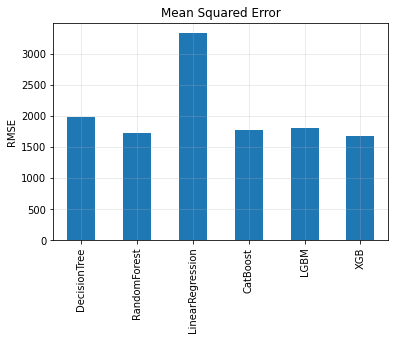

In [161]:
final_infos['RMSE'].plot(kind = 'bar')

plt.title('Mean Squared Error')
plt.ylabel('RMSE')
plt.grid(alpha = 0.3)
plt.show()

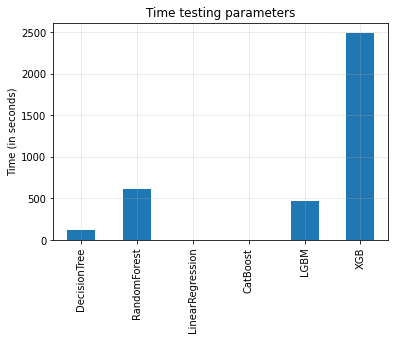

In [162]:
final_infos['param_time'].plot(kind = 'bar')

plt.title('Time testing parameters')
plt.grid(alpha = 0.3)
plt.ylabel('Time (in seconds)')

plt.show()

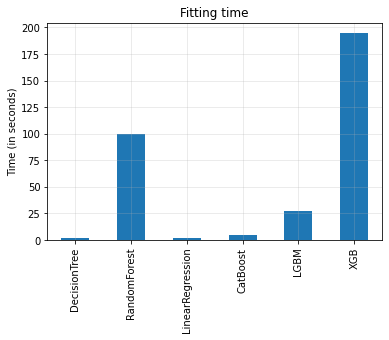

In [164]:
final_infos['fit_time'].plot(kind = 'bar')

plt.title('Fitting time')
plt.ylabel('Time (in seconds)')
plt.grid(alpha = 0.3)
plt.show()

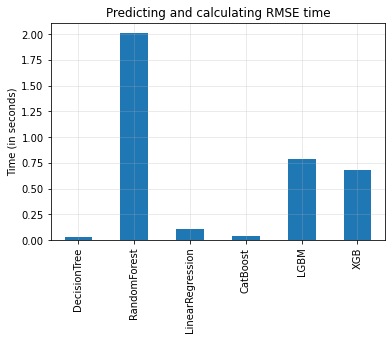

In [163]:
final_infos['predict_time'].plot(kind = 'bar')

plt.title('Predicting and calculating RMSE time')
plt.ylabel('Time (in seconds)')
plt.grid(alpha = 0.3)
plt.show()

Despite XGB Regressor delivering the best RMSE result, it significantly requires more time for both fitting and testing various parameters—compared to the substantially shorter time intervals for testing the same parameters with LGBM and DecisionTree. Additionally, the results from RandomForest and CatBoost appear quite comparable, suggesting they are strong contenders. Considering both fitting and predicting times, CatBoost emerges as a more efficient choice for our objectives.

## Testing the selected model

Considering the prior results, we'll proceed with the CatBoostRegressor. Utilizing our test dataset, here are the outcomes:

In [168]:
test_time_1 = time.time()

predicted_test = model_cat.predict(features_test)
RMSE_cat_test = mean_squared_error(predicted_test, target_test) ** 0.5

test_time_2 = time.time()

print(f'The RMSE for the test dataset is {RMSE_cat_test}. The testing process took {test_time_2 - test_time_1} seconds.')

The RMSE for the test dataset is 1756.5770737430112. The testing process took 0.039595603942871094 seconds.


The result was calculated really fast, and we obtained an interesting result.